In [1]:
import reno

Reno allows creating stock and flow models (https://en.wikipedia.org/wiki/Stock_and_flow) and defining the equations for each.

Stocks, flows, and variables can be added to a model by directly defining them as attributes on the model.

Equations can either be specified in the flow/variable constructor, or later by assigning the `.eq` attribute. This is to allow creating all necessary components and then referencing them within equations. Note that when a stock is referenced in an equation, it's referring to its _previous_ timestep value, while referencing flows and variables is always the current timestep's value. This means that you can have circular references between stocks, but flows and variables need to be able to resolve dependency ordering (no circular references)

Note that stocks are only defined in terms of inflows and outflows, which you can do with corresponding `my_model.my_stock += my_inflow` and `my_model.my_stock -= my_outflow` lines

Reno currently only handles discrete timestep simulations, so all equations are "difference equations" rather than true differential equations.

Separate metric component equations (e.g. with the `Metric` class) can be used which run after a simulation is complete to allow computing aggregate statistics or observables.

In [2]:
t = reno.TimeRef()
tub = reno.Model("Tub", doc="Model the amount of water in a bathtub based on a drain and faucet rate.")
tub.faucet, tub.drain = reno.Flow(), reno.Flow(dtype=float)
tub.water_level = reno.Stock()

tub.faucet_off_time = reno.Variable(5, doc="When to turn the faucet off in the simulation.")

tub.water_level += tub.faucet
tub.water_level -= tub.drain

tub.faucet.eq = reno.Piecewise([5, 0], [t < tub.faucet_off_time, t >= tub.faucet_off_time])
tub.drain.eq = reno.sin(t) + 2
tub.drain.min = 0
tub.drain.max = tub.water_level

tub.final_water_level = reno.Metric(tub.water_level.timeseries[-1])

Run a model's `graph()` function to get a graphviz output of the overall system

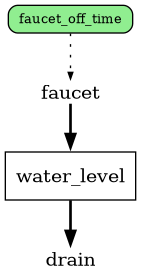

In [3]:
tub.graph()

Use a model's `latex()` function to get a more palatable (and interactive) printout of all of the equations in the system. Clicking a line will highlight where the corresponding variable is used.

In [4]:
tub.latex()

InteractiveLatex(events=['fire_on_row_clicked'], latex_output=Output(), template=Template(template='<template>…

Call the model like a function to run a simulation. The output is an xarray dataset with the full timeseries for every stock/flow/variable/metric

In [5]:
tub()

Tub:   0%|          | 0/9 [00:00<?, ?it/s]

<xarray.Dataset> Size: 344B
Dimensions:            (sample: 1, step: 10)
Coordinates:
  * sample             (sample) int64 8B 0
  * step               (step) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    water_level        (sample, step) float64 80B 0.0 5.0 7.159 ... 10.45 7.457
    faucet             (sample, step) int64 80B 5 5 5 5 5 0 0 0 0 0
    drain              (sample, step) float64 80B 0.0 2.841 ... 2.989 2.412
    faucet_off_time    (sample) int64 8B 5
    final_water_level  (sample) float64 8B 7.457
Attributes:
    faucet_off_time:  Scalar(5)
    water_level_0:    0

The `latex()` function can be used for debugging after a simulation run by specifying a timestep to look at. Every component will include (in red) the value of that component at that timestep.

In [6]:
tub.latex(t=5)

InteractiveLatex(events=['fire_on_row_clicked'], latex_output=Output(), template=Template(template='<template>…

In [7]:
print(tub.get_docs())

Model the amount of water in a bathtub based on a drain and faucet rate.

Example:
	Tub(faucet_off_time=5, water_level_0=None)

Args:
	faucet_off_time: When to turn the faucet off in the simulation.
	water_level_0


Any free variables of the system (as well as the number of timesteps to execute) can be set for a specific run by passing them as parameters to the model call.  

In [8]:
tub(steps=30, faucet_off_time=10)

Tub:   0%|          | 0/29 [00:00<?, ?it/s]

<xarray.Dataset> Size: 984B
Dimensions:            (sample: 1, step: 30)
Coordinates:
  * sample             (sample) int64 8B 0
  * step               (step) int64 240B 0 1 2 3 4 5 6 ... 23 24 25 26 27 28 29
Data variables:
    water_level        (sample, step) float64 240B 0.0 5.0 7.159 ... 0.0 0.0 0.0
    faucet             (sample, step) int64 240B 5 5 5 5 5 5 5 ... 0 0 0 0 0 0 0
    drain              (sample, step) float64 240B 0.0 2.841 2.909 ... 0.0 0.0
    faucet_off_time    (sample) int64 8B 10
    final_water_level  (sample) float64 8B 0.0
Attributes:
    faucet_off_time:  Scalar(10)
    water_level_0:    0

The system can also run multiple samples in parallel by specifying an `n` variable. In the call below, we run 3 parallel simulations for 30 steps, and specify a `List` distribution for the `faucet_off_time` variable, meaning that each sample will pull a different value from the list.

In [9]:
ds1 = tub(steps=30, n=3, faucet_off_time=reno.List([10, 15, 20]))
ds1

Tub:   0%|          | 0/29 [00:00<?, ?it/s]

<xarray.Dataset> Size: 2kB
Dimensions:            (sample: 3, step: 30)
Coordinates:
  * sample             (sample) int64 24B 0 1 2
  * step               (step) int64 240B 0 1 2 3 4 5 6 ... 23 24 25 26 27 28 29
Data variables:
    water_level        (sample, step) float64 720B 0.0 5.0 7.159 ... 44.34 42.07
    faucet             (sample, step) int64 720B 5 5 5 5 5 5 5 ... 0 0 0 0 0 0 0
    drain              (sample, step) float64 720B 0.0 2.841 ... 2.271 1.336
    faucet_off_time    (sample) int64 24B 10 15 20
    final_water_level  (sample) float64 24B 0.0 17.07 42.07
Attributes:
    faucet_off_time:  List([10, 15, 20])
    water_level_0:    0

The system can be diagrammed with little sparkplots next to each stock to help visualize the data running through them.

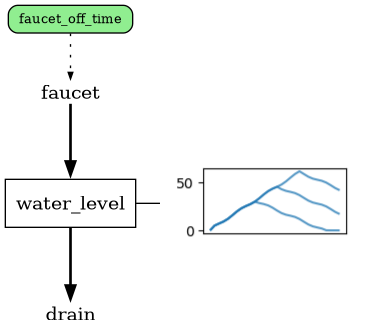

In [10]:
tub.graph(sparklines=True)

Beyond just `List`, Reno has several probability distributions, such as `Normal`, so when specifying e.g. 100 samples to run in parallel, each sample will randomly pull from that distribution and execute with that chosen value. 

In [11]:
ds2 = tub(n=1000, faucet_off_time=reno.Normal(10, 5))
ds2

Tub:   0%|          | 0/9 [00:00<?, ?it/s]

<xarray.Dataset> Size: 264kB
Dimensions:            (sample: 1000, step: 10)
Coordinates:
  * sample             (sample) int64 8kB 0 1 2 3 4 5 ... 995 996 997 998 999
  * step               (step) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    water_level        (sample, step) float64 80kB 0.0 5.0 7.159 ... 25.45 27.46
    faucet             (sample, step) int64 80kB 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5
    drain              (sample, step) float64 80kB 0.0 2.841 ... 2.989 2.412
    faucet_off_time    (sample) float64 8kB 12.27 8.844 11.53 ... -1.436 16.11
    final_water_level  (sample) float64 8kB 27.46 27.46 27.46 ... 0.0 27.46
Attributes:
    faucet_off_time:  Normal(10, 5)
    water_level_0:    0

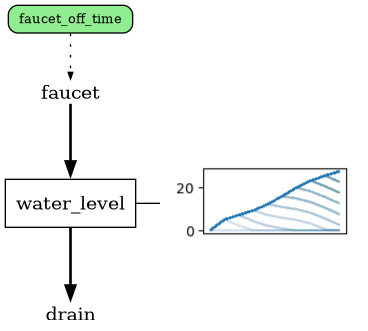

In [12]:
tub.graph(sparklines=True)

Reno comes with some functions to help plot/compare specified variables across one or more simulation runs (the datasets produced from model calls). You can specify variable names as strings, or directly pass the component references, as will be shown later.

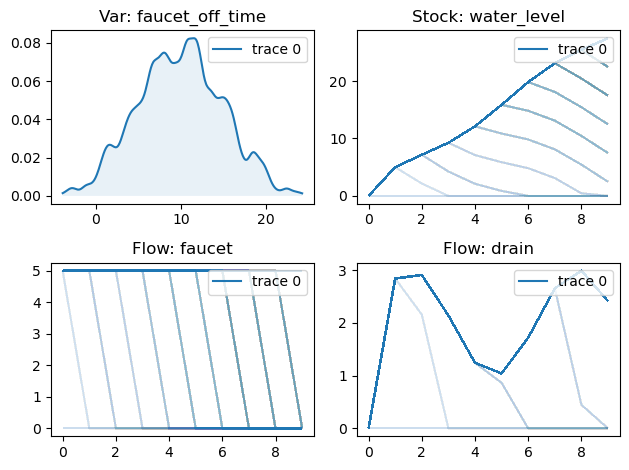

In [13]:
reno.plot_trace_refs(tub, [ds2], ["faucet_off_time", "faucet", "drain", "water_level"])

Reno models can be converted on the fly to PyMC equivalent code, and run in a similar way. The `.pymc` function mimics the normal model call function in that you can specify any free variables, as well as a few specific parameters to control the PyMC run process. In this example, since we have no data to infer from yet, we can just run priors (forward modeling) using PyMC, by passing `compute_prior_only=True`.

In [14]:
ds3 = tub.pymc(n=1000, compute_prior_only=True, faucet_off_time=reno.Normal(10, 5))

Sampling: [faucet_off_time]


We run the same plot as previously to show the pymc prior runs are roughly equivalent to Reno's default math system/forward modeling.

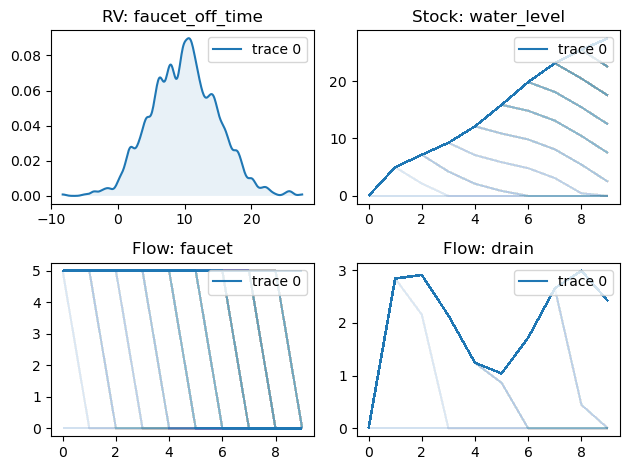

In [15]:
reno.plot_trace_refs(tub, [ds3.prior], ["faucet_off_time", "faucet", "drain", tub.water_level])

We can run Bayesian inference by specifying an observation to target - `Observation`s are observed data for any system metrics, which are then modeled as a likelihood function, normally distributed with the specified sigma value.

In [16]:
ds4 = tub.pymc(n=1000, faucet_off_time=reno.Normal(10, 5), observations=[reno.Observation(tub.final_water_level, 5.0, [12.0])])

Sampling: [faucet_off_time, final_water_level_likelihood]
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

/home/81n/micromamba/envs/reno/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


We plot the difference between the prior and posterior by passing in both datasets to the traces argument. (Note here that we pass as a dictionary instead of a list - when a dictionary is passed, the keys are used in the plot legends)

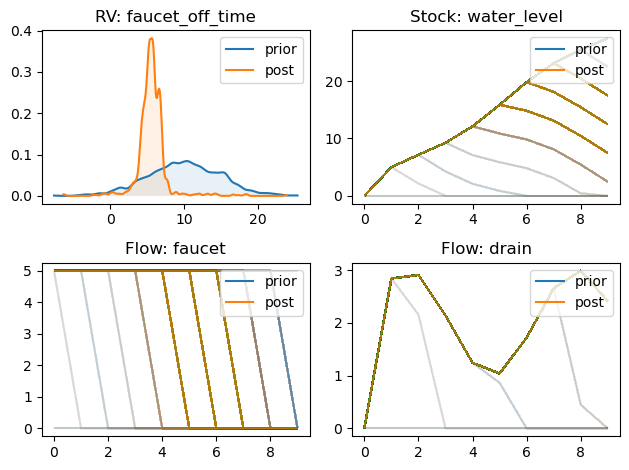

In [17]:
reno.plot_trace_refs(tub, {"prior": ds4.prior, "post": ds4.posterior}, ["faucet_off_time", "faucet", "drain", "water_level"])

We can add in spark plots to every component in a diagram by specifying `sparklines`, `sparkall`, and `sparkdensities` as `True`

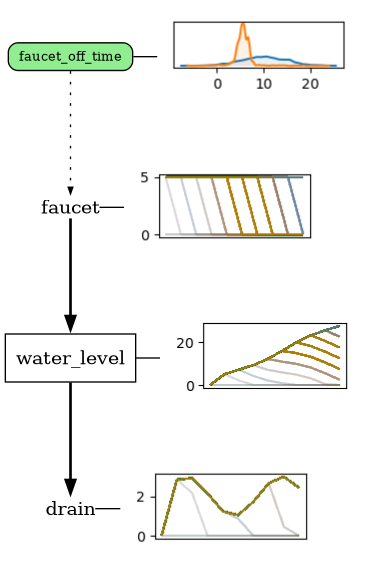

In [18]:
tub.graph(sparklines=True, sparkall=True, sparkdensities=True, traces=[ds4.prior, ds4.posterior])